In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import seaborn as sns
import scipy.stats as stats

import yfinance as yf
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from matplotlib import cm

In [2]:
df = pd.read_csv('data/Data_PCLab1_Stock.csv')

In [3]:
df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


## Task 1. Visualization and 1st step toward the CAPM
### Use the PCLab_Data.xlsx to produce scatter plots of each stocks’ daily returns against the market daily returns

In [4]:
cols = [col for col in df.columns if col != 'Date']
stock_cols = [col for col in cols if col != 'sp500']

In [5]:
def calculate_daily_returns(returns, cols):
    # Create a new DataFrame with the same index to store returns
    returns = df[['Date']].copy()
    
    # Calculate daily returns for the specified columns in one go
    returns[cols] = df[cols].pct_change() * 100  # Multiply by 100 for percentages

    # Drop the first row with NaN values resulting from pct_change()
    return returns.dropna()

In [6]:
returns = calculate_daily_returns(df, cols)

In [7]:
returns.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
1,2012-01-13,-0.374946,-1.205144,-0.166006,1.813685,1.415339,-0.769869,-19.327430,-0.738516,-0.494792
2,2012-01-17,1.164812,0.857909,0.598603,-0.809717,1.815943,0.468852,16.717854,0.574410,0.355295
3,2012-01-18,1.038382,-0.239234,0.264463,3.918367,4.282725,0.594448,0.789470,0.688856,1.110793
4,2012-01-19,-0.316937,0.666134,0.296736,0.549882,2.644634,-0.303752,-0.186494,1.052283,0.493866
5,2012-01-20,-1.741670,-0.052939,0.295858,-1.250000,-1.810236,4.431642,-0.597907,-8.377507,0.066946


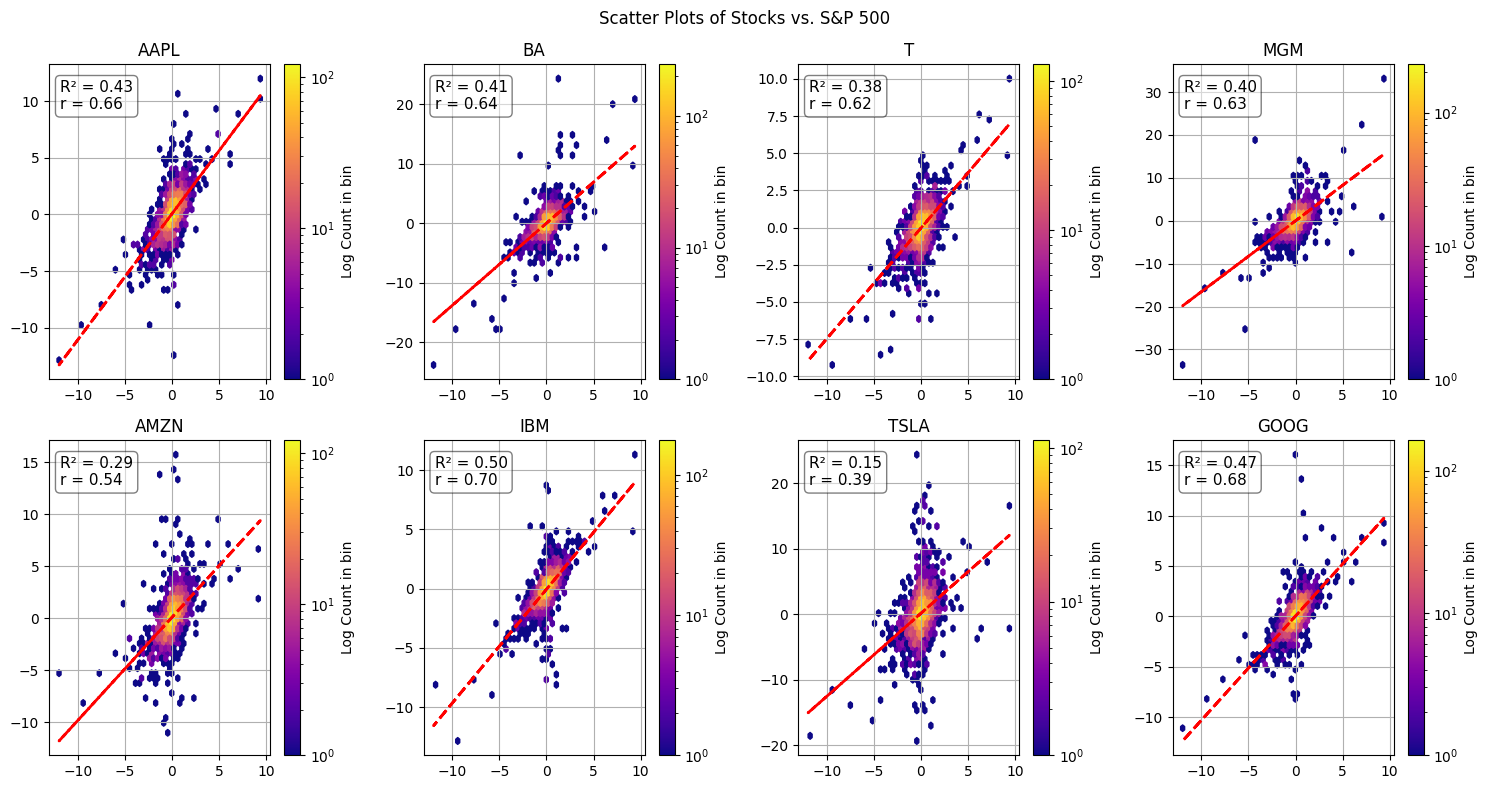

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Scatter Plots of Stocks vs. S&P 500')

for ax, stock in zip(axs.flatten(), stock_cols):
    # Create hexbin plot with logarithmic normalization to handle sparsity
    hb = ax.hexbin(returns["sp500"], returns[stock], gridsize=50, cmap='plasma', 
                   norm=LogNorm(), mincnt=1)
    
    # Add a color bar with logarithmic scaling
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Log Count in bin')
    
    ax.set_title(stock)

    # Calculate linear regression (trend line)
    slope, intercept = np.polyfit(returns["sp500"], returns[stock], 1)
    trendline = slope * returns["sp500"] + intercept
    
    # Plot trend line
    ax.plot(returns["sp500"], trendline, color='red', linestyle='--', linewidth=2)

    # Calculate R² and Pearson correlation coefficient
    r_squared = r2_score(returns[stock], trendline)
    pearson_corr, _ = pearsonr(returns["sp500"], returns[stock])

    # Display R² value in the upper left corner of the plot
    ax.text(0.05, 0.95, f'R² = {r_squared:.2f}\nr = {pearson_corr:.2f}', transform=ax.transAxes, fontsize=11, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.grid(True)

plt.tight_layout()
plt.show()


### Comment: is there an apparent correlation? Strong? For which stock?
Correlation is particularly strong for major tech stocks such as Alphabet, Apple and IBM. They have very high market capitalizations (especially the first two), making them significant components of the S&P 500 index, meaning that any movement in their prices can disproportionately influence the broader market. Moreover, since these are growth-oriented companies, their valuations and future prospects are closely tied to general economic indicators and investor sentiment. It doesn’t directly apply to Amazon because the company significantly benefited from COVID-19. With retail and cloud computing as its main sources of revenue, Amazon experienced increased e-commerce demand due to widespread lockdowns and saw a rise in Amazon Web Services usage as many businesses and individuals moved their activities online.

Boeing shows moderate correlation with the market. Although it is a big company that mostly follows market trends, it is heavily influenced by the aerospace and defense industry dynamics, which can cause deviations from general market trends. Moreover, Boeing’s performance in this period was affected by the 737 MAX crisis, which created uncertainty and volatility for the stock.

MGM Resorts had lower correlation because it is primarily influenced by the travel and entertainment industry, which is sensitive to consumer discretionary spending and macroeconomic conditions rather than general market trends. AT&T also showed relatively low correlation with the market because telecommunications is a defensive industry which is less sensitive to overall market trends. 

Tesla has the weakest correlation because its stock price is often influenced by factors specific to the electric vehicle industry, technological advancements, and investor speculation. The S&P 500 may not fully capture the same risk or growth factors, leading to a weaker correlation.

## Task 2. Compute alpha and beta
### Apply the CAPM: run an OLS regression of stock $i$ returns on market returns, over the whole period. Assume $r_f = 0$. Are the estimates significant?

CAPM: $ \tilde{r}_i - r_f = \alpha_i + \beta_i (\tilde{r}_M - r_f) + \epsilon_i $

If we assume $r_f = 0$, it simplifies to $\tilde{r}_i = \alpha_i + \beta_i \tilde{r}_M + \epsilon_i$

In [9]:
X = returns[['sp500']]
y = returns['AAPL']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create and fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     1640.
Date:                Fri, 04 Oct 2024   Prob (F-statistic):          3.52e-267
Time:                        18:35:30   Log-Likelihood:                -3690.8
No. Observations:                2158   AIC:                             7386.
Df Residuals:                    2156   BIC:                             7397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0528      0.029      1.831      0.0

The estimate of $\alpha$ is not-significant (p-value $> 0.05$), the estimate of $\beta$ is significant (p-value $< 0.05$).

### Plot the beta and alpha for the 8 stocks. Which stock has the highest (lowest) beta and alpha? Comment!

In [10]:
alphas = []
betas = []
alpha_LBs = []
beta_LBs = []
alpha_UBs = []
beta_UBs = []

for stock in stock_cols:
    X = returns[['sp500']]
    y = returns[stock]

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    alphas.append(model.params['const'])
    betas.append(model.params['sp500'])
    
    # Get confidence intervals
    conf_int = model.conf_int()
    alpha_LBs.append(conf_int.loc['const', 0])
    alpha_UBs.append(conf_int.loc['const', 1])
    beta_LBs.append(conf_int.loc['sp500', 0])
    beta_UBs.append(conf_int.loc['sp500', 1])

results = pd.DataFrame({
    'Stock': stock_cols, 
    'Alpha': alphas, 
    'Beta': betas,
    'Alpha LB': alpha_LBs,
    'Alpha UB': alpha_UBs,
    'Beta LB': beta_LBs,
    'Beta UB': beta_UBs
})

In [11]:
results

,Stock,Alpha,Beta,Alpha LB,Alpha UB,Beta LB,Beta UB
0,AAPL,0.052837,1.112891,-0.003746,0.109419,1.059004,1.166779
1,BA,-0.002292,1.382867,-0.075563,0.070979,1.313086,1.452649
2,T,-0.028577,0.744630,-0.070644,0.013490,0.704566,0.784694
3,MGM,-0.016893,1.653568,-0.106942,0.073155,1.567808,1.739328
4,AMZN,0.102261,0.991732,0.033634,0.170889,0.926373,1.057092
5,IBM,-0.053480,0.960416,-0.096454,-0.010506,0.919489,1.001343
6,TSLA,0.175917,1.268611,0.042248,0.309586,1.141308,1.395915
7,GOOG,0.033371,1.034881,-0.015497,0.082239,0.988340,1.081422


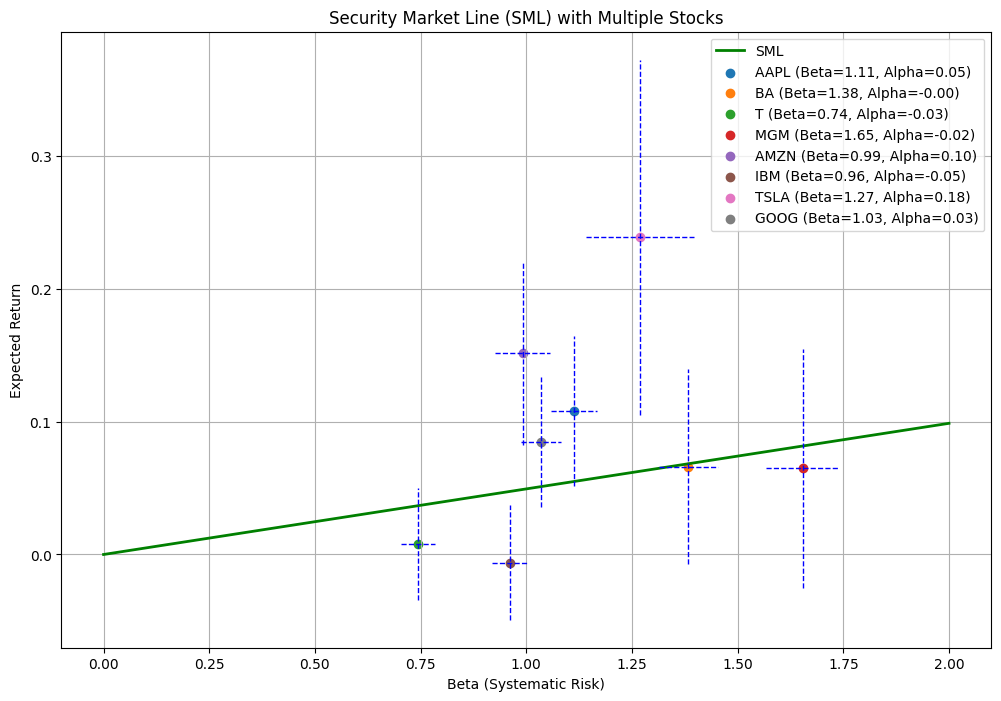

In [12]:
risk_free_rate = 0
market_risk_premium = returns[['sp500']].mean().iloc[0]  # Market return - risk-free rate

# Generate beta values for plotting SML
beta_values = np.linspace(0, 2, 100)
sml_returns = risk_free_rate + beta_values * market_risk_premium

# Plot the Security Market Line (SML)
plt.figure(figsize=(12, 8))
plt.plot(beta_values, sml_returns, label='SML', color='green', lw=2)

# Plot each stock with its beta, alpha, and the bounds
for idx, row in results.iterrows():
    # Expected return based on CAPM
    expected_return = risk_free_rate + row['Beta'] * market_risk_premium
    
    # Actual return with alpha
    actual_return = expected_return + row['Alpha']
    
    # Plot the stock point
    plt.scatter(row['Beta'], actual_return, label=f"{row['Stock']} (Beta={row['Beta']:.2f}, Alpha={row['Alpha']:.2f})")
    
    # Plot the upper and lower bounds for Beta and Alpha
    plt.vlines(row['Beta'], row['Alpha LB'] + risk_free_rate + row['Beta'] * market_risk_premium, 
               row['Alpha UB'] + risk_free_rate + row['Beta'] * market_risk_premium, color='blue', linestyle='--', lw=1)
    
    plt.hlines(actual_return, row['Beta LB'], row['Beta UB'], color='blue', linestyle='--', lw=1)

# Customize the plot
plt.title('Security Market Line (SML) with Multiple Stocks')
plt.xlabel('Beta (Systematic Risk)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In the plot, all the stocks above the SML line are outperforming the market, indicating they have a positive alpha.

On the other hand, the stocks below the line are underperforming relative to their risk level.

However, it's also clear that the uncertainty in the estimations complicates matters, as with a 95% confidence level, certain alpha values could potentially change sign.

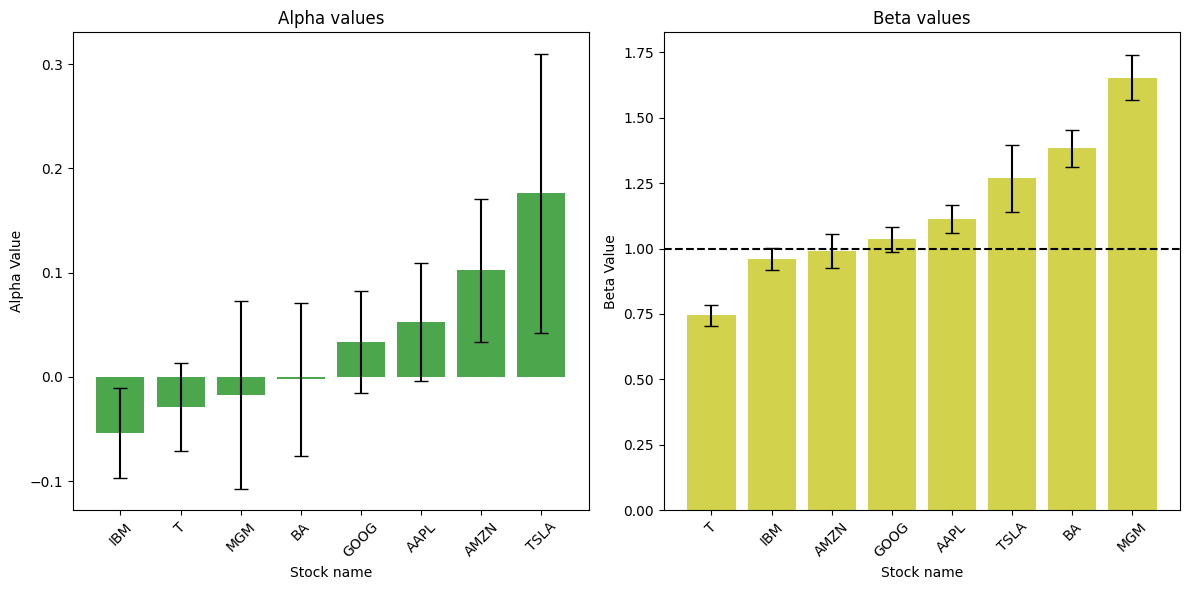

In [13]:
sorted_results = results.sort_values(by=['Alpha', 'Beta'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

metrics = ['Alpha', 'Beta']
colors = ['g', 'y']
titles = ['Alpha values', 'Beta values']

# Loop through each metric and plot
for idx, (metric, color, title) in enumerate(zip(metrics, colors, titles)):
    sorted_metric = results.sort_values(by=metric)
    indices = np.arange(len(sorted_metric))
    
    # Determine the confidence interval bounds
    if metric == 'Alpha':
        yerr = [sorted_metric[metric] - sorted_metric['Alpha LB'], sorted_metric['Alpha UB'] - sorted_metric[metric]]
    elif metric == 'Beta':
        yerr = [sorted_metric[metric] - sorted_metric['Beta LB'], sorted_metric['Beta UB'] - sorted_metric[metric]]

    # Bar plot with error bars
    axes[idx].bar(indices, sorted_metric[metric], color=color, label=metric, yerr=yerr, capsize=5, alpha=0.7)
    axes[idx].set_xlabel('Stock name')
    axes[idx].set_ylabel(f'{metric} Value')
    axes[idx].set_title(title)
    axes[idx].set_xticks(indices)
    axes[idx].set_xticklabels(sorted_metric['Stock'], rotation=45)
    
    # Horizontal line for Beta = 1 reference
    if metric == 'Beta':
        axes[idx].axhline(y=1, color='black', linestyle='--', label='Beta = 1')

plt.tight_layout()
plt.show()


The highest alpha value: TESLA \
The lowest alpha value: IBM

The highest beta value: MGM \
The lowest beta value: 	AT&T

### Use the observed returns and the predicted ones to compute and plot the histogram of error terms $\varepsilon_i$ for each stock. Comment!

In [14]:
predictions = pd.DataFrame({'Date': returns['Date']})

for index, row in results.iterrows():
    stock = row['Stock']
    alpha = row['Alpha']
    beta = row['Beta']
    # Generate predictions for each stock
    predictions[stock] = alpha + beta * returns['sp500']

# Dataframe with error terms (actual - predicted)
data_error = returns[stock_cols] - predictions[stock_cols]

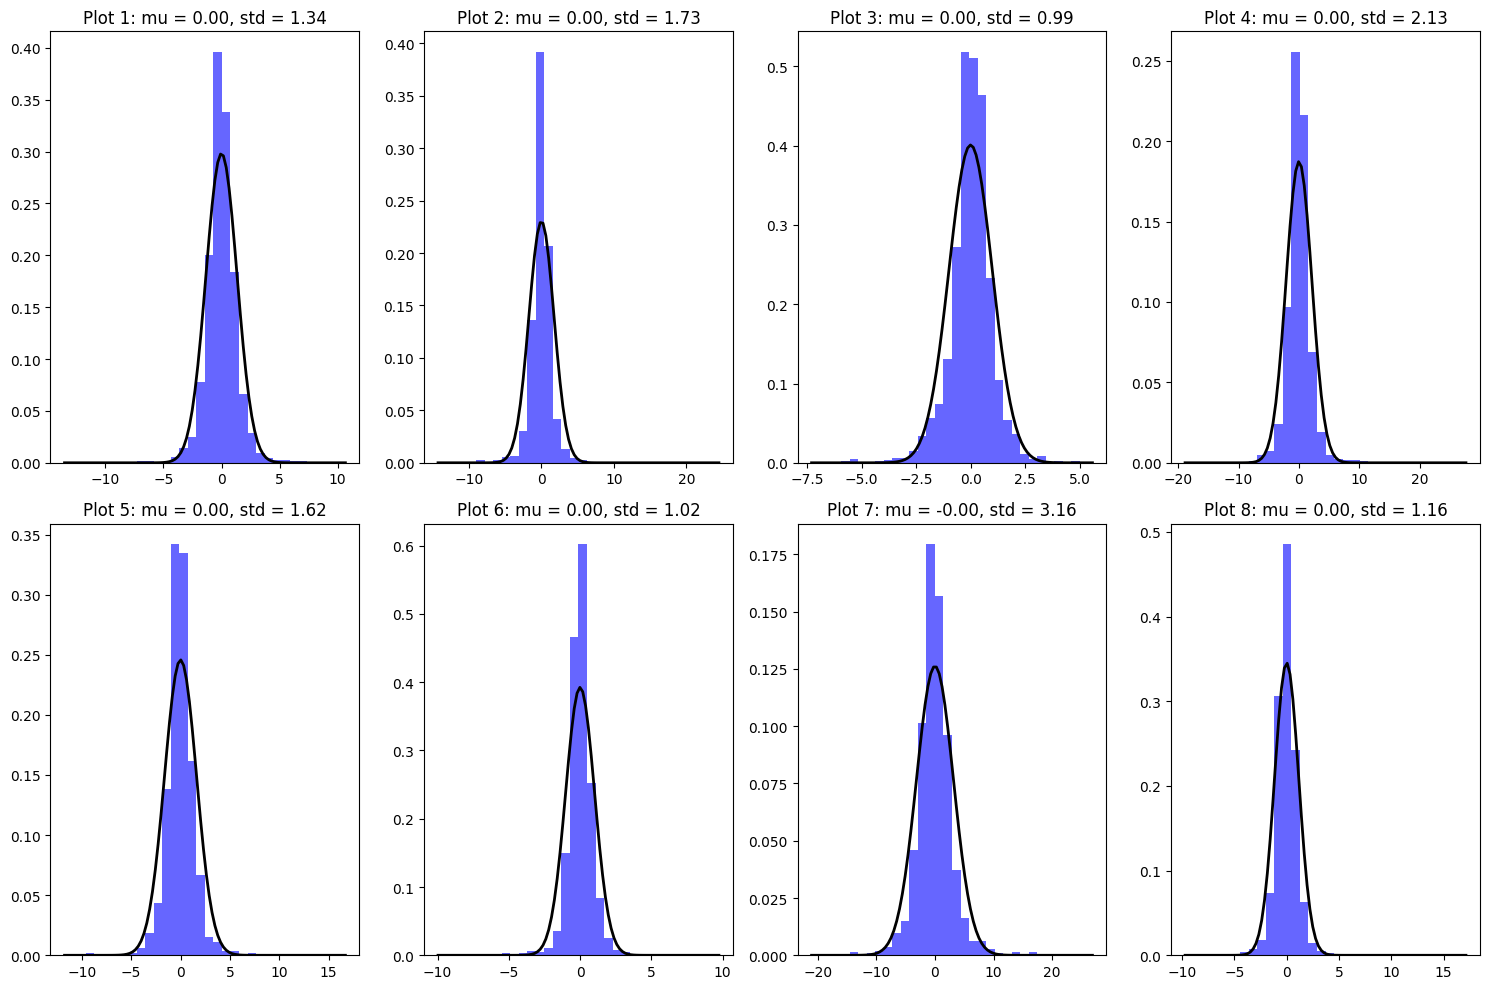

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 rows, 4 columns of subplots
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easy iteration

for i, ax in enumerate(axes):
    # Assuming data_error has multiple columns, you can iterate through them
    data = data_error.iloc[:, i]  # Access the i-th column of the data
    
    # Plot histogram
    ax.hist(data, bins=30, density=True, alpha=0.6, color='blue')  # Use density=True for normalized histogram
    
    # Fit the data to a normal distribution
    mu, std = stats.norm.fit(data)
    
    # Create a range of values for the normal curve
    xmin, xmax = ax.get_xlim()  # Get the x-axis limits for each subplot
    x = np.linspace(xmin, xmax, 100)
    
    # Plot the normal PDF
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    
    # Add a title for each subplot with the mean and std
    ax.set_title(f'Plot {i+1}: mu = {mu:.2f}, std = {std:.2f}')

plt.tight_layout()
plt.show()

Plotting the residuals it appears they have E($ε_i$) = 0. Their distribution is clearly not Gaussian.

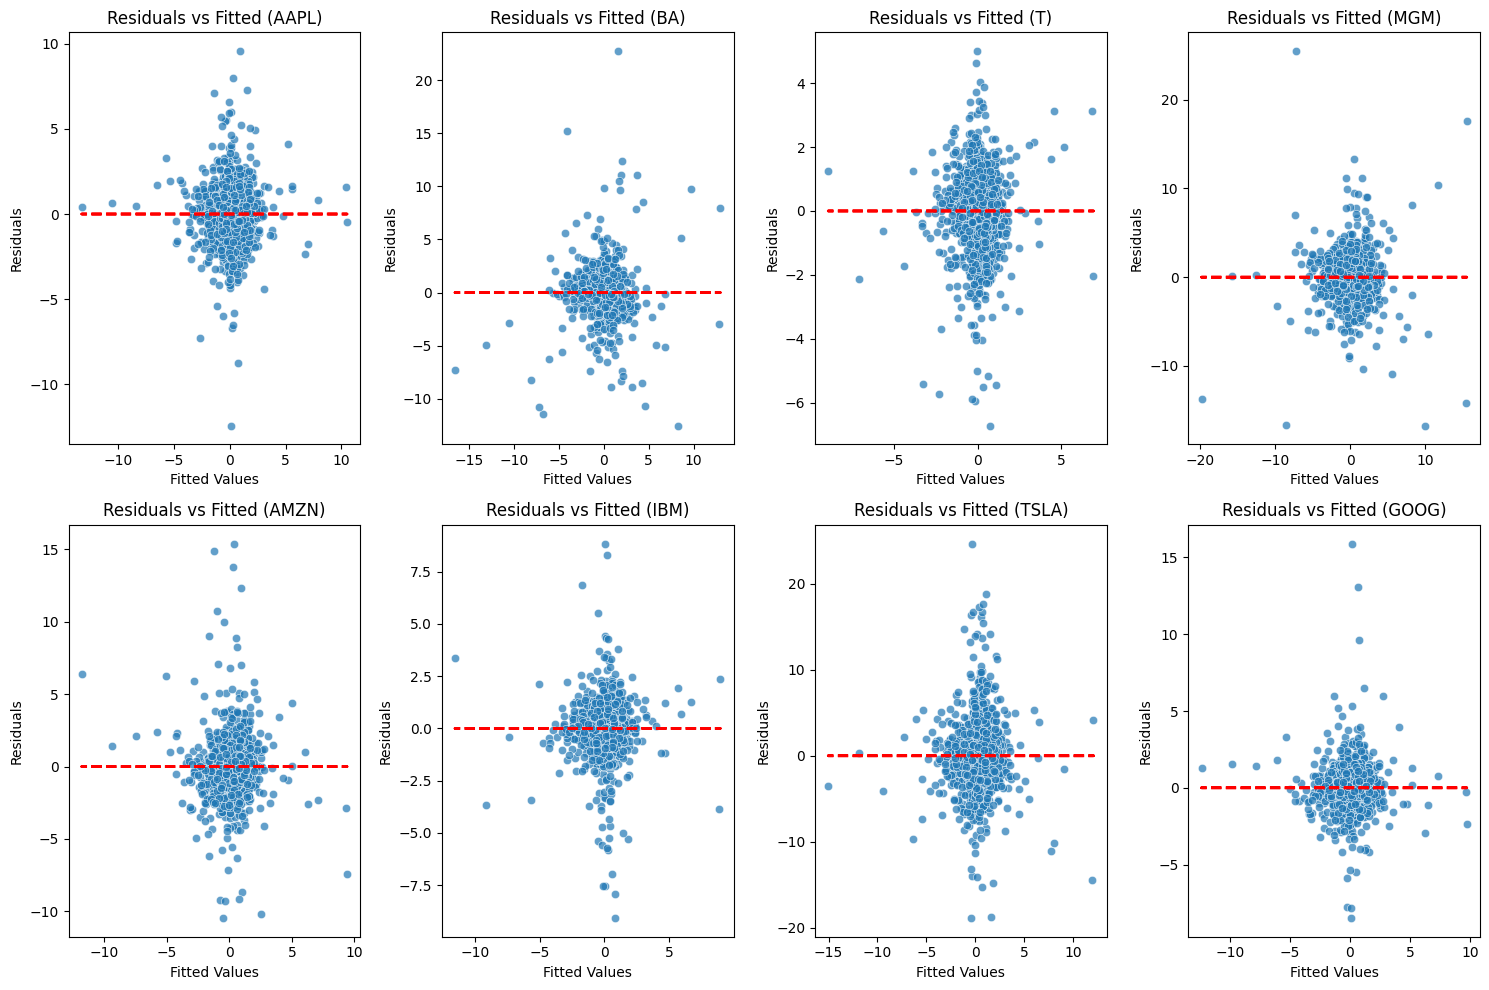

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()  # Flatten to 1D for easy iteration

for i, stock in enumerate(stock_cols):
    fitted_values = predictions[stock]  # Predicted values for this stock
    residuals = data_error[stock]  # Residuals for this stock (actual - predicted)
    
    # Create the residual vs fitted values plot for each stock
    sns.scatterplot(x=fitted_values, y=residuals, ax=axes[i], alpha=0.7)

    # Calculate slope and intercept for the trend line
    slope, intercept = np.polyfit(fitted_values, residuals, 1)
    trendline = slope * fitted_values + intercept
    
    # Plot the trend line
    axes[i].plot(fitted_values, trendline, color='red', linestyle='--', linewidth=2)
    
    # Add labels and title
    axes[i].set_title(f'Residuals vs Fitted ({stock})')
    axes[i].set_xlabel('Fitted Values')
    axes[i].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

The residuals appear to be fairly evenly scattered around zero without a clear pattern, suggesting no obvious heteroskedasticity.

### Your boss wants to take a lot of risk to deliver high return. He asks you to (i) select the 4 riskier assets (over the full period), (ii) form an equally weighted portfolio, and (iii) to estimate the portfolio return based on parameters ($β$ and $r_m$) estimated above.

In [17]:
for col in cols: # we check which of the stocks are the most risky by computing standard deviation
    print(f'{col}: {df[col].std()}')

AAPL: 70.82760132839695
BA: 103.67858597481984
T: 3.2074898522656086
MGM: 6.963847046140431
AMZN: 697.8389049336641
IBM: 25.561937789518428
TSLA: 210.98800293601448
GOOG: 334.44805694402015
sp500: 537.3217268874763


4 most risky assets are: Amazon, Google, Tesla and Boeing. \
Now we are creating the portfolio with all of them equally weighted.

In [18]:
alphaA = results[results['Stock'] == "AMZN"]["Alpha"].sum() #Amazon alpha
betaA = results[results['Stock'] == "AMZN"]["Beta"].sum() #Amazon beta

alphaG = results[results['Stock'] == "GOOG"]["Alpha"].sum() #Google alpha
betaG = results[results['Stock'] == "GOOG"]["Beta"].sum() #Google beta

alphaT = results[results['Stock'] == "TSLA"]["Alpha"].sum() #Tesla alpha
betaT = results[results['Stock'] == "TSLA"]["Beta"].sum() #Tesla beta

alphaB = results[results['Stock'] == "BA"]["Alpha"].sum() #Boeing alpha
betaB = results[results['Stock'] == "BA"]["Beta"].sum() #Boeing beta

In [19]:
covariance_matrix = returns.drop('Date', axis=1).cov()
sp500_variance = covariance_matrix.loc['sp500', 'sp500']

stocks_of_interest = ['AMZN', 'GOOG', 'TSLA', 'BA']
portfolio_covariance_matrix = covariance_matrix.loc[stocks_of_interest, stocks_of_interest]

# Define an equally weighted portfolio 
weights = np.array([0.25, 0.25, 0.25, 0.25])

# Calculate the overall portfolio risk
portfolio_risk = weights.T @ portfolio_covariance_matrix @ weights

portfolio_risk, sp500_variance

(2.7032914052998587, 1.100580024769798)

In [20]:
market = returns['sp500'].mean()
predicted_return = (alphaA + alphaG + alphaT + alphaB)/4 + (betaA+betaG+betaT+betaB)/4*market
predicted_return

0.13501726538113382

In [21]:
print(f'The market yielded a return equal to {market*100:.2f}%, while the CAPM predicted a return of {predicted_return*100:.2f}% for the selected portfolio.')
print(f'The market risk was {sp500_variance}, while the porfolio risk was {portfolio_risk}.')

The market yielded a return equal to 4.93%, while the CAPM predicted a return of 13.50% for the selected portfolio.
The market risk was 1.100580024769798, while the porfolio risk was 2.7032914052998587.


In [24]:
portfolio_stocks = ['AMZN', 'GOOG', 'TSLA', 'BA']
predictions_portfolio = pd.DataFrame()
predictions_portfolio['Date'] = predictions['Date']
predictions_portfolio['portfolio_return'] = predictions[portfolio_stocks].mean(axis=1)

In [35]:
# Function takes one parameter: time and returns the return after specified time and the plot
# of portfolio's return over time
def portfolio_value(time): 
    if time > 2157:  # if the time is larger than 2157, it's changed to 2157
        print("Maximum number is 2157")
        time = 2157
    value = [1]  # Use 1 as the initial value for the portfolio over time
    portfolio_return = []  # Return of the portfolio over time
    for i in range(time):
        value.append(value[-1] * (100 + predictions_portfolio.iloc[i, -1]) / 100)  # Updating values
        portfolio_return.append(value[-1] * 100 / 1 - 100)  # Updating values based on 1 as the initial value
    print(f'Return after period {time} is {value[-1] * 100 / 1 - 100} %')
    port_df = pd.DataFrame({"Date": returns['Date'][0:time],
                            "portfolio_return": portfolio_return})
    # Plot
    ax = port_df.plot(x='Date', y='portfolio_return', figsize=(10, 6), legend=False, color='b')
    ax.set_title("Portfolio Return Over Time", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Portfolio Return (%)", fontsize=12)
    ax.grid(True)
    plt.show()

Return after period 100 is 9.881328729026578 %


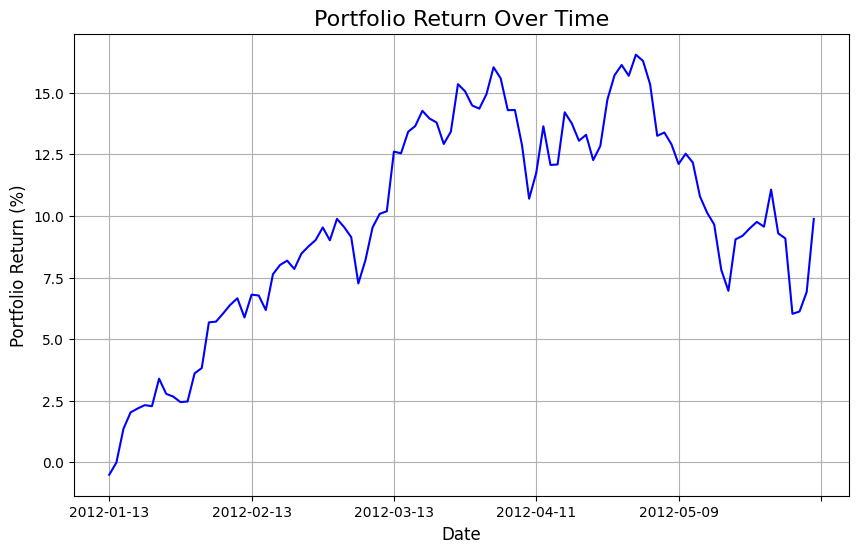

In [36]:
portfolio_value(100)

## Task 3: Testing the CAPM theory
### For each year : compute $β^{y−1}_i$ over 252 business days at the end of each year $y − 1$ (OLS regression)
### At the end of year $y$, compare the average return of the stock $\bar{r}_i^y$ (annualized) to the one predicted by the CAPM model $\hat{r}_M^y$ (using $\beta_i^{y-1}$ measured at $y$).

In [43]:
returns['Date'] = pd.to_datetime(returns['Date'])

test_df = pd.DataFrame()
years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
all_years_dataframes = []

for year in years:
    df_year = returns[returns['Date'].dt.year == year]
    year_data = []
    for stock in stock_cols:
        x_mean = df_year[['sp500']].mean().iloc[0] 
        X = df_year[['sp500']]
        y = df_year[stock]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        
        alpha = model.params['const']
        beta = model.params['sp500']
        
        stock_dict = {'alpha':alpha, 'beta':beta, 'return_sp500': x_mean, 'stock': stock}
        year_data.append(stock_dict)
        
    df_year = pd.DataFrame(year_data)
    df_year.set_index('stock', inplace=True)  
    all_years_dataframes.append((year , df_year))  
projected_returns_df = pd.concat([df for year, df in all_years_dataframes], keys=[year for year, df in all_years_dataframes])

In [44]:
dic = {}
for year in years:
    data = projected_returns_df.loc[year]
    if year == 2012:
        alpha = data['alpha'] # I compute b and a the previous year.
        beta = data['beta']
        continue
    projections = alpha + np.array(beta)*np.array(data['return_sp500'])
    dic[year] = projections
    alpha = data['alpha']
    beta = data['beta']

    
projections_df = pd.DataFrame(pd.concat(dic, axis=0))
projections_df['projections'] = projections_df['alpha']
projections_df = projections_df.drop('alpha', axis = 1)


In [45]:
all_years_dataframes = []
for year in years:
    df_year = returns[returns['Date'].dt.year == year]
    year_data = []
    for stock in stock_cols:
        m = df_year[stock].mean()
        
        year_data.append({'stock':stock, 'returns': m})
        
    df_year = pd.DataFrame(year_data)
    df_year.set_index('stock', inplace=True)
    all_years_dataframes.append((year, df_year))  

real_returns_df = pd.concat([df for year, df in all_years_dataframes], keys=[year for year, df in all_years_dataframes])       

In [40]:
final = pd.merge(real_returns_df, projections_df, left_index=True, right_index=True, how='outer')
final = final.drop(index=2012)
final = final[['returns', 'projections']]
final

returns  projections
     stock                       
2013 AAPL   0.037324     0.194123
     AMZN   0.198451     0.236365
     BA     0.244859     0.070149
     GOOG   0.191911     0.111996
     IBM   -0.001340     0.083156
...              ...          ...
2020 GOOG   0.103138     0.050214
     IBM    0.009248     0.021622
     MGM   -0.015871     0.074324
     T     -0.130829     0.103628
     TSLA   0.952558     0.075127

[64 rows x 2 columns]

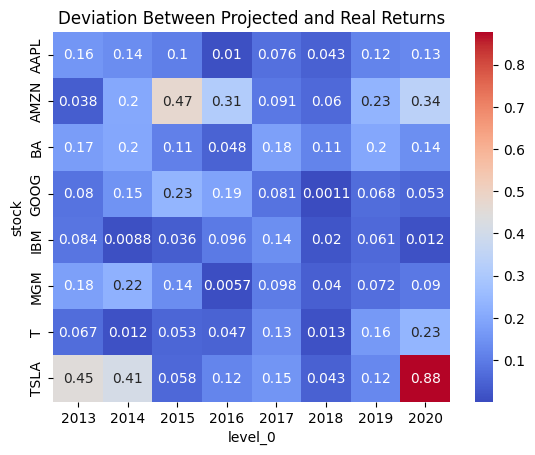

In [46]:
df = final.copy()
# Add a deviation column (abs difference between projected and real returns)
df['Deviation'] = abs(df['projections'] - df['returns'])

# Reset index to turn multi-index into columns and pivot for heatmap
df_reset = df.reset_index()
deviation_pivot = df_reset.pivot(index='stock', columns='level_0', values='Deviation')

sns.heatmap(deviation_pivot, cmap='coolwarm', annot=True)
plt.title('Deviation Between Projected and Real Returns')
plt.show()

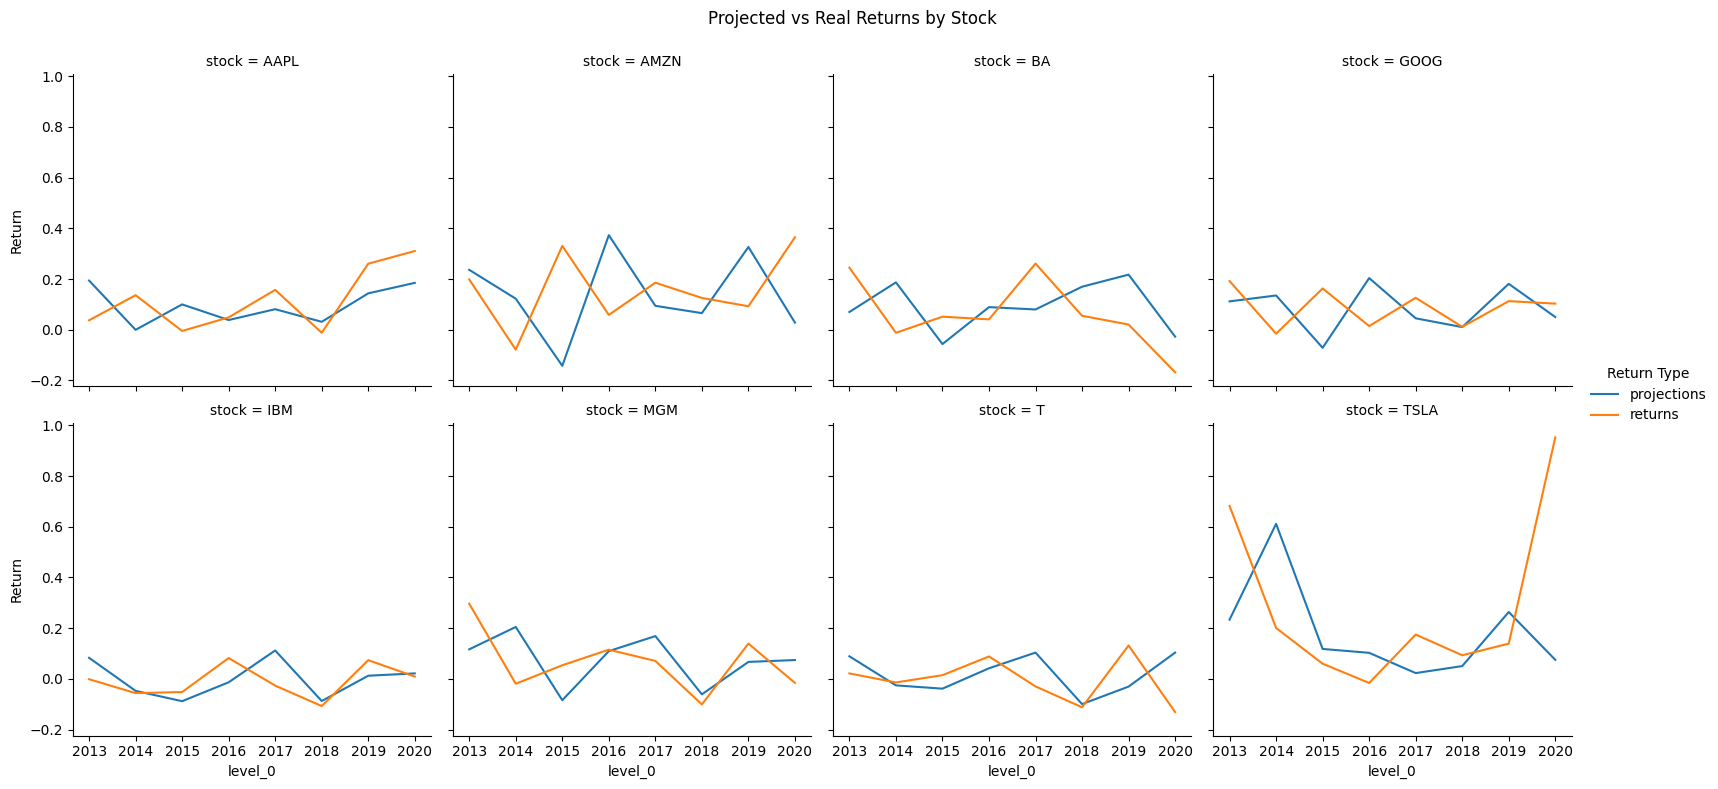

In [47]:
df_reset = final.reset_index()

df_melted = df_reset.melt(id_vars=['level_0', 'stock'], value_vars=['projections', 'returns'], 
                          var_name='Return Type', value_name='Return')

g = sns.FacetGrid(df_melted, col='stock', hue='Return Type', col_wrap=4, height=4)
g.map(sns.lineplot, 'level_0', 'Return').add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Projected vs Real Returns by Stock')
plt.show()

For some stocks, such as IBM, we can observe that the CAPM model yields good approximations of the actual returns. In other cases, the model diverges significantly. For example, regarding TSLA, during the period 2015–2019, the predictions were reasonably accurate, but for the years 2013 and 2020, the model completely missed the mark.

## Task 4 (Optional)

1. Get the list of S&P500 tickers
2. Use the list as input to get the data from Yahoo Finance
3. Describe and comment on the data, why do you have more variables than in the provided file?
4. Besides the optional task, we have also done an optional optional task, first retrieving all of the tickers that existed in the 8 year history of the S&P500
5. looking at the change of the composition of the S&P500: core question, is the S&P500 a weighted average of the stocks or is it more skewed towards the so-called "Magnificent 7"

### 1. List of S&P500 tickets

In [49]:
def get_snp_tickers():
    req = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    soup = BeautifulSoup(req.content, 'html.parser')
    data = list()
    
    # Loop over the different table rows in the table
    for row in soup.select(".wikitable")[0].select("tbody tr"):
        try:
            # To make sure not the entries without tickers are found, we use a try except
            ticker = row.select('td')[0].text.replace("\n", "")
            industry = row.select('td')[2].text
            data.append({"ticker": ticker, "industry": industry})
        except:
            pass

    return pd.DataFrame(data)
snp_tickers = get_snp_tickers()
print(snp_tickers.shape)
snp_tickers.head()

(503, 2)


,ticker,industry
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology


#### Comments
What is interesting is that the S&P500 does not actually contain 500 tickers, but rather 503. This is because some of the companies have multiple share classes, such as Google and Berkshire Hathaway. They have this for different purposes, such as retaining control in the company (Google or Alphabet has this with A and C shares, where the A shares have almost all of the decision power). 
Another thing to note is that this list is the current S&P500 collection of tickers. This collection changes over time, for different reasons such as a change in market capitalization, such as is the case for Palantir (PLTR) this year or because of a bankrupcy or merger. We will investigate the impact of the diversification of the stocks within the S&P500 in a bit. For this we also want to see the division of industries and we therefor also scraped this information. 

### 2. Get data from Yahoo Finance

In [50]:
tickers = list(snp_tickers['ticker'])
tickers[0:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [51]:
start = "2012-01-12"
end = "2020-08-11"

In [52]:
def get_timeseries(ticker, start, end):
    try:
        data = yf.download(ticker, start=start, end=end)
        data.reset_index(inplace=True)
        data['date'] = data['Date'].dt.strftime('%d-%m-%Y')
        d = data[['date', 'Close', 'Open', 'High', 'Low']]
        d.rename({"Open": f"{ticker}_open", "Close": f"{ticker}_close", "High": f"{ticker}_high", "Low": f"{ticker}_low"}, axis=1, inplace=True)
        return d    
    except Exception as e:
        data = yf.download(ticker, period='max')
        data.reset_index(inplace=True)
        data['date'] = data['Date'].dt.strftime('%d-%m-%Y')
        d = data[['date', 'Close', 'Open', 'High', 'Low']]
        d.rename({"Open": f"{ticker}_open", "Close": f"{ticker}_close", "High": f"{ticker}_high", "Low": f"{ticker}_low"}, axis=1, inplace=True)
        return d

In [53]:
def create_dataset(tickers, start="2012-01-12", end="2020-08-11"):
    not_found = []

    data = get_timeseries(tickers[0], start, end)
    
    for i, ticker in enumerate(tickers):
        # print(ticker)
        if i == 0:
            continue
        try:
            t_data = get_timeseries(ticker, start, end)
            # print(data.columns)
            data = pd.merge(data, t_data, on="date", how="left")
        except AttributeError:
            not_found.append(ticker)
            continue        

    return data, not_found


dataset, not_found = create_dataset(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABNB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2012-01-12 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for

In [54]:
not_found

['BRK.B', 'BF.B']

Here we see that three tickers cannot be found by the API, these are:
- Berkshire Hathaway Inc Class B
- Brown-Forman Corporation Class B
- Jacobs Engineering Group

We were not able to find any alternative solution besides collecting the data manually, which we only found to be able on yearly intervals, which would have taken us too much time.

### 3. Describe and comment on the data, why do you have more variables than in the provided file?
This file has around 4 times more variables, because besides the daily stock price data, we also have some statistics of the intraday behaviour of the price. Whereas the provided xlsx file contains only 1 price point per day, the data from Yahoo contains 6 prices. We have taken only the Low, High, Open and Close as these are the most important ones. An example of a visualization of the pricing data that is often used is the so-called candlesticks. A candlestick contains the four points of information that we have gathered and shows these into an intuitive format: we can immediately see the open and close, which is the candle itself, visualized by a thick green or red bar (green meaning close is higher than open and red meaning close is lower than open) and sticks that point out of either side indicating the low and high of that period (in our case day).

In [55]:
mmm = dataset[['date', 'MMM_close', 'MMM_open', 'MMM_high', 'MMM_low']].head(20)
fig = go.Figure(data=[go.Candlestick(x=mmm['date'],
                                     open=mmm['MMM_open'],
                                     high=mmm['MMM_high'],
                                     low=mmm['MMM_low'],
                                     close=mmm['MMM_close'])])
fig.update_layout(title='MMM interday price change 12-01-2012 to 09-02-2012',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)
fig.show()

### 4. Optional Optional Task: getting all of the historical S&P500 entries
If the tickers have not been delisted, we use a historical list of S&P500 entries that were removed after rebalancing to get a bigger dataset of companies. We stick to the starting date of the xlsx file, to make sure we do not have 1300+ entries. We did this as follows:
- We found a list of S&P500 entries on Github, downloaded the csv.
- We retrieved the unique list of tickers from this csv.
- We retrieved the tickers, where applicable.

In [57]:
def load_data(file_name="snp500_change.csv", start="2012-01-12"):
    df = pd.read_csv(file_name)
    df["date"] = pd.to_datetime(df["date"])
    new_df = df[df['date'] > start]
    return new_df


new_df = load_data()

def get_unique_tickers(df):
    unique_tickers = set()
    objs = df.to_dict("records")
    for obj in objs:
        unique_tickers = unique_tickers.union(obj['tickers'].split(","))

    print(f"Found {len(unique_tickers)} tickers")
    return list(unique_tickers)


tickers = get_unique_tickers(new_df)

Found 771 tickers


In [58]:
def create_dataset(file_name="snp500.csv", start="2012-01-12", end="2020-08-11"):
    not_found = []
    df = load_data()
    tickers = get_unique_tickers(df)
    tickers = list(set(tickers))

    data = get_timeseries(tickers[0], start, end)
    data.rename({"Open": f"{tickers[0]}_open", "Close": f"{tickers[0]}_close", "High": f"{tickers[0]}_high", "Low": f"{tickers[0]}_low"}, axis=1, inplace=True)
    
    for i, ticker in enumerate(tickers):
        if i == 0:
            continue
        try:
            t_data = get_timeseries(ticker, start, end)
        except AttributeError:
            not_found.append(ticker)
            continue
        t_data.rename({"Close": f"{ticker}_close", "Open": f"{ticker}_open", "Low": f"{ticker}_low", "High": f"{ticker}_high"}, axis=1, inplace=True)
        try:
            # This is a problem with NFLX possibly due to a name change. 
            # print(t_data.shape)
            data = pd.merge(data, t_data, on="date", how="left")
        except:
            print(ticker)
            continue
    return data, not_found


dataset, not_found = create_dataset()

Found 771 tickers


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MYL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MYL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JOY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2012-01-12 -> 2020-08-11)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JOY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1925-10-29 -> 2024-10-04)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 o

The following tickers were not found. Some of them are logical, because they went bankrupt or merged with another company. Others are not retrieved for unknown reasons. 

In [59]:
print(not_found)

['MYL', 'JOY', 'TIF', 'ENDP', 'DISCA', 'HSH', 'WIN', 'HSP', 'RE', 'DISCK', 'BLL', 'KRFT', 'RTN', 'BTUUQ', 'XL', 'ABMD', 'BRCM', 'VIAB', 'RRD', 'APOL', 'CTL', 'LIFE', 'BBBY', 'SYMC', 'DNR', 'ARNC', 'MXIM', 'MJN', 'HCBK', 'VIAC', 'QEP', 'KORS', 'ALXN', 'CAM', 'AABA', 'FII', 'LLTC', 'UTX', 'TE', 'ABC', 'VAR', 'CVC', 'MON', 'FRX', 'WRK', 'FLIR', 'SIAL', 'GGP', 'SNDK', 'STJ', 'RDC', 'ETFC', 'JCP', 'WLTW', 'LSI', 'DWDP', 'WPX', 'BBT', 'CDAY', 'APC', 'WYND', 'ANTM', 'LM', 'BF.B', 'LXK', 'FTR', 'TWC', 'TMK', 'MNK', 'TSS', 'BCR', 'ARG', 'XEC', 'NLOK', 'MWV', 'RAI', 'SIVB', 'PKI', 'SPLS', 'ADS', 'PBCT', 'NLSN', 'DTV', 'NYX', 'BXLT', 'BRK.B', 'WCG', 'CERN', 'BHGE', 'CBS', 'WFM', 'XLNX', 'FRC', 'RHT', 'ATVI', 'CMCSK', 'JEC', 'TWTR', 'ANRZQ', 'NVLS', 'COG', 'GMCR', 'LVLT', 'HFC', 'LO', 'CTXS', 'AVP', 'LLL', 'PEAK', 'ESV', 'PGN', 'CPGX', 'HRS', 'DF', 'INFO', 'DRE', 'DISH', 'FLT', 'PXD', 'FB', 'FDO', 'AGN', 'CFN', 'CELG', 'FBHS', 'NBL', 'SWY', 'CXO', 'KSU']


We found a total of 2564/4 = 641 S&P500 entries that were still listed. This is 138 more than is currently in the S&P500. We store this in a new file, which we can potentially use in the calculations for the CAPM model, but also for future assignments.

In [60]:
dataset.shape

(1211, 2569)

In [61]:
dataset.rename({"HAS": "HAS_close", "Open": "HAS_open", "High": "HAS_high", "Low": "HAS_low"}, axis=1, inplace=True)

In [62]:
dataset.to_csv("snp500_stocks.csv", index=False)

### Optional Optional Optional Task: plot the distribution of the S&P500 in 2012 and 2024
With the rise of Big Tech, we feel that the S&P500 has shifted from being a well distributed index to one that is weighted mainly by N big companies. We want to test this and check what the distribution looks like for the current S&P500, both in terms of companies and in terms of sectors and compare that to the S&P500 in 2012. For this we need to do a little bit more scraping of the second table on Wikipedia to get the industries also for the ex-S&P500 tickers.

> NOTE: it is important to note that we make an assumption here and merely look at the shift in composition of the S&P500. We do not have the historical market cap of the stocks in 2012. We use the currently outstanding shares to calculate the market cap of the companies in 2012.

We do this little research as follows:
- We retrieve the market cap of the stocks at this point in time
- We then plot the composition of the S&P500 in terms of market cap as of 2024 (today)
- Then we plot the composition of the S&P500 according to industry
- We then collect the industries of the different ex-S&P500 listed companies
- We then calculate the estimated market cap of these companies as described above
- We compare the two distributions.

#### Retrieve Market Cap

In [63]:
def getMarketCap(ticker):
    try:
        stock = yf.Ticker(ticker)
        # Get the market capitalization
        market_cap = stock.info['marketCap']
        return market_cap
    except:
        return None


snp_tickers['market_cap'] = snp_tickers.apply(lambda x: getMarketCap(x['ticker']), axis=1)

In [64]:
snp_tickers.to_csv("market_cap.csv")

#### Plot Composition
To provide a good plot composition, we provide a plot in which we bin the 10 highest together: 10 highest together, second 10 highest together etc.

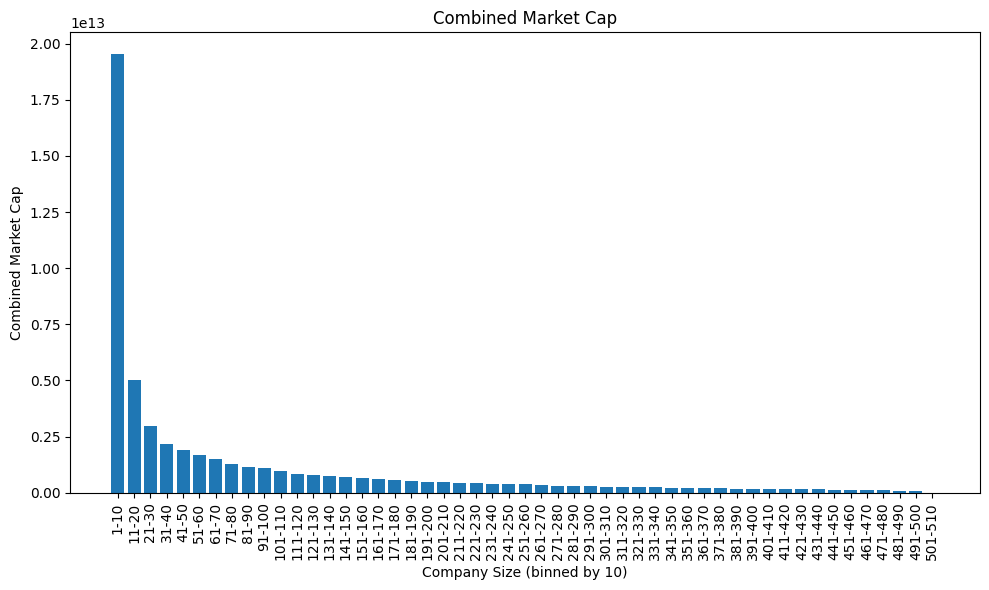

In [65]:
df = snp_tickers.sort_values('market_cap', ascending=False)
bin_size = 10
bins = [df['market_cap'].iloc[i:i + bin_size].sum() for i in range(0, len(df), bin_size)]

# Create bin labels (e.g., "Top 10", "Next 10", etc.)
labels = [f'{i+1}-{i+bin_size}' for i in range(0, len(df), bin_size)]

# Plot the combined market caps
plt.figure(figsize=(10, 6))
plt.bar(labels, bins)

# Add labels and title
plt.xlabel('Company Size (binned by 10)')
plt.ylabel('Combined Market Cap')
plt.title('Combined Market Cap')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

Here we see that the top 10 companies in the S&P500 make up a large amount of the total market cap. 

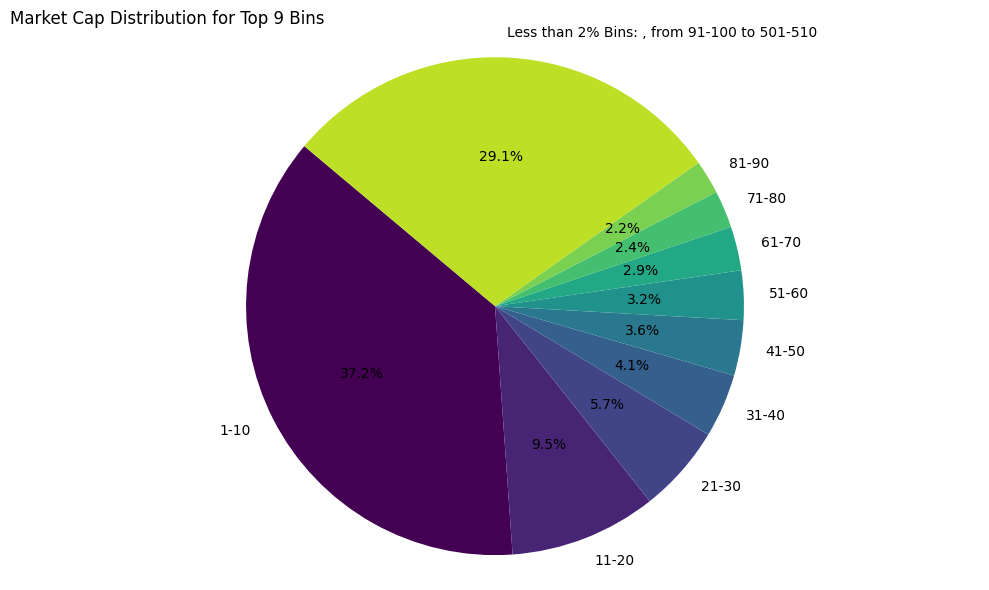

In [66]:
bin_size = 10
binned_data = []

# Binning the data
for i in range(0, len(df), bin_size):
    bin_sum = df['market_cap'].iloc[i:i + bin_size].sum()
    binned_data.append(bin_sum)

# Create bin labels (e.g., "1-10", "11-20", etc.)
labels = [f'{i+1}-{i+bin_size}' for i in range(0, len(df), bin_size)]

# Prepare data for pie chart
binned_df = pd.DataFrame({
    'Bin': labels,
    'market_cap': binned_data
})

# Calculate the total market cap
total_market_cap = binned_df['market_cap'].sum()

# Filter to include only the top 9 bins
top_bins_df = binned_df.nlargest(9, 'market_cap')

# Calculate market cap for the "Less than 2%" group
less_than_2_percent_cap = binned_df.loc[~binned_df.index.isin(top_bins_df.index), 'market_cap'].sum()

# Create a string to show the bin ranges for "Less than 2%"
less_than_2_percent_bins = binned_df.loc[~binned_df.index.isin(top_bins_df.index), 'Bin'].tolist()
less_than_2_percent_label = ('Less than 2% Bins: ' + ', ' + 'from ' + less_than_2_percent_bins[0] +' to ' +  less_than_2_percent_bins[-1])

# Create a new DataFrame for the pie chart
final_bins_df = pd.concat([top_bins_df.set_index('Bin'), 
                            pd.DataFrame({'market_cap': [less_than_2_percent_cap]}, index=[less_than_2_percent_label])])

# Colors for the pie chart
colors = cm.viridis([i / len(final_bins_df) for i in range(len(final_bins_df))])

# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(final_bins_df['market_cap'], labels=final_bins_df.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Market Cap Distribution for Top 9 Bins', loc='left')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

# Show the plot
plt.tight_layout()
plt.show()

In [67]:
less_than_2_percent_bins[-1]

'501-510'

Here we can see this even better: we see that the 10 biggest stocks take up around 40% of the whole market cap of the S&P500. These include the Magnificant 7, which have seen a meteoric rise in market capitalization. Now lets look at the separation between industries

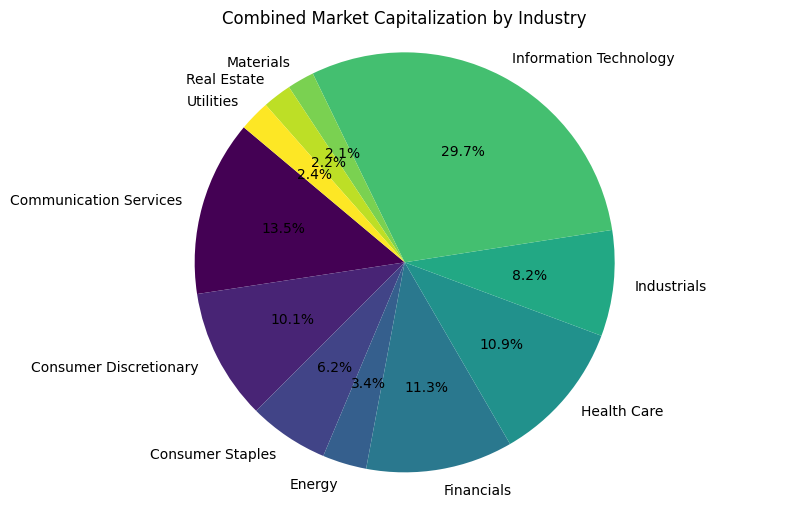

In [68]:
industry_market_cap = df.groupby('industry')['market_cap'].sum().reset_index()

cmap = plt.get_cmap("viridis")  # Choose a colormap
colors = cmap(np.linspace(0, 1, len(industry_market_cap)))

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(industry_market_cap['market_cap'], labels=industry_market_cap['industry'], autopct='%1.1f%%', startangle=140, colors = colors)
plt.title('Combined Market Capitalization by Industry')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

In [69]:
industry_market_cap['industry'].unique()

array(['Communication Services', 'Consumer Discretionary',
       'Consumer Staples', 'Energy', 'Financials', 'Health Care',
       'Industrials', 'Information Technology', 'Materials',
       'Real Estate', 'Utilities'], dtype=object)

Here we can see that our hunch was correct: Information Technology companies such as Nvidia, Microsoft and Google take up around 30% of the whole S&P500 index. Let's see what it looked like 12 years ago.

#### Situation in 2012
To analyse this, we first need to retrieve the S&P500 entries from that year.

In [70]:
df = pd.read_csv("snp500_change.csv")
tickers_2012 = list(df[df['date'] == '2012-01-12']['tickers'])[0].split(",")
len(tickers_2012)

497

It is interesting that there are only 497 stocks. Literature suggests that this is due to mergers and acquisitions in the months before and it could be that new stocks were not added to the index, because rebalancing is done on a quarterly basis. Now lets retrieve the industries belonging to them. Because this information is not available on the Wikipedia page, we used ChatGPT to categorize the stocks instead by asking: categorize the following stocks in the categories: 'Communication Services', 'Consumer Discretionary',
       'Consumer Staples', 'Energy', 'Financials', 'Health Care',
       'Industrials', 'Information Technology', 'Materials',
       'Real Estate', 'Utilities'

In [71]:
changed = []

current = snp_tickers['ticker'].to_list()

for t in tickers_2012:
    if t not in current:
        changed.append(t)

In [72]:
ticker_industry_depr = {
    'AABA': 'Communication Services',
    'ABC': 'Health Care',
    'AET': 'Health Care',
    'AGN': 'Health Care',
    'AIV': 'Real Estate',
    'ALTR': 'Information Technology',
    'AN': 'Consumer Discretionary',
    'ANDV': 'Energy',
    'ANF': 'Consumer Discretionary',
    'ANRZQ': 'Energy',
    'ANTM': 'Health Care',
    'APC': 'Energy',
    'APOL': 'Consumer Discretionary',
    'ARG': 'Materials',
    'ARNC': 'Industrials',
    'ATGE': 'Consumer Discretionary',
    'ATI': 'Materials',
    'AVP': 'Consumer Staples',
    'BBBY': 'Consumer Discretionary',
    'BBT': 'Financials',
    'BCR': 'Health Care',
    'BEAM': 'Materials',
    'BHGE': 'Energy',
    'BIG': 'Consumer Discretionary',
    'BLL': 'Materials',
    'BMC': 'Health Care',
    'BMS': 'Materials',
    'BRCM': 'Information Technology',
    'BTUUQ': 'Energy',
    'CA': 'Information Technology',
    'CAM': 'Energy',
    'CBE': 'Materials',
    'CBS': 'Communication Services',
    'CCE': 'Consumer Staples',
    'CELG': 'Health Care',
    'CERN': 'Health Care',
    'CFN': 'Health Care',
    'CHK': 'Energy',
    'CLF': 'Materials',
    'CMA': 'Financials',
    'CNX': 'Energy',
    'COG': 'Energy',
    'COL': 'Industrials',
    'COV': 'Health Care',
    'CTL': 'Communication Services',
    'CTXS': 'Information Technology',
    'CVC': 'Communication Services',
    'CVH': 'Health Care',
    'DF': 'Consumer Staples',
    'DISCA': 'Communication Services',
    'DNB': 'Information Technology',
    'DNR': 'Energy',
    'DO': 'Energy',
    'DTV': 'Communication Services',
    'DXC': 'Information Technology',
    'EMC': 'Information Technology',
    'EP': 'Energy',
    'ESRX': 'Health Care',
    'ETFC': 'Financials',
    'FDO': 'Consumer Staples',
    'FHN': 'Financials',
    'FII': 'Financials',
    'FISV': 'Information Technology',
    'FLIR': 'Industrials',
    'FLR': 'Industrials',
    'FLS': 'Materials',
    'FRX': 'Health Care',
    'FTI': 'Energy',
    'FTR': 'Communication Services',
    'GAS': 'Utilities',
    'GHC': 'Communication Services',
    'GME': 'Consumer Discretionary',
    'GNW': 'Financials',
    'GPS': 'Consumer Discretionary',
    'GR': 'Industrials',
    'GT': 'Consumer Discretionary',
    'HAR': 'Industrials',
    'HCBK': 'Financials',
    'HCP': 'Health Care',
    'HNZ': 'Consumer Staples',
    'HOG': 'Consumer Discretionary',
    'HOT': 'Consumer Discretionary',
    'HP': 'Energy',
    'HRB': 'Consumer Discretionary',
    'HRS': 'Industrials',
    'HSH': 'Consumer Staples',
    'HSP': 'Health Care',
    'IGT': 'Consumer Discretionary',
    'JCP': 'Consumer Discretionary',
    'JEC': 'Industrials',
    'JEF': 'Financials',
    'JOY': 'Industrials',
    'JWN': 'Consumer Discretionary',
    'KSS': 'Consumer Discretionary',
    'LB': 'Consumer Discretionary',
    'LEG': 'Consumer Staples',
    'LIFE': 'Health Care',
    'LLL': 'Industrials',
    'LLTC': 'Information Technology',
    'LM': 'Financials',
    'LNC': 'Financials',
    'LO': 'Consumer Staples',
    'LSI': 'Real Estate',
    'LXK': 'Information Technology',
    'M': 'Consumer Discretionary',
    'MAT': 'Consumer Discretionary',
    'MHS': 'Health Care',
    'MJN': 'Consumer Staples',
    'MMI': 'Communication Services',
    'MOLX': 'Health Care',
    'MON': 'Materials',
    'MUR': 'Energy',
    'MWV': 'Materials',
    'MYL': 'Health Care',
    'NBL': 'Energy',
    'NBR': 'Energy',
    'NE': 'Energy',
    'NFX': 'Energy',
    'NOV': 'Energy',
    'NVLS': 'Information Technology',
    'NWL': 'Consumer Discretionary',
    'NYX': 'Financials',
    'OI': 'Materials',
    'PBCT': 'Financials',
    'PBI': 'Information Technology',
    'PCL': 'Materials',
    'PCP': 'Materials',
    'PDCO': 'Health Care',
    'PGN': 'Energy',
    'PKI': 'Health Care',
    'PLL': 'Materials',
    'POM': 'Utilities',
    'PRGO': 'Health Care',
    'PX': 'Materials',
    'PXD': 'Energy',
    'QEP': 'Energy',
    'R': 'Industrials',
    'RAI': 'Consumer Staples',
    'RDC': 'Energy',
    'RHI': 'Financials',
    'RHT': 'Information Technology',
    'RRC': 'Energy',
    'RRD': 'Communication Services',
    'RTN': 'Industrials',
    'S': 'Communication Services',
    'SCG': 'Utilities',
    'SE': 'Energy',
    'SEE': 'Materials',
    'SHLD': 'Consumer Discretionary',
    'SIAL': 'Materials',
    'SLM': 'Financials',
    'SNDK': 'Information Technology',
    'SNI': 'Communication Services',
    'SPLS': 'Consumer Discretionary',
    'SRCL': 'Industrials',
    'STI': 'Financials',
    'STJ': 'Health Care',
    'SUN': 'Energy',
    'SVU': 'Consumer Staples',
    'SWN': 'Energy',
    'SWY': 'Consumer Staples',
    'SYMC': 'Information Technology',
    'TDC': 'Information Technology',
    'TE': 'Utilities',
    'TEG': 'Utilities',
    'TGNA': 'Communication Services',
    'THC': 'Health Care',
    'TIE': 'Energy',
    'TIF': 'Consumer Discretionary',
    'TMK': 'Financials',
    'TRIP': 'Consumer Discretionary',
    'TSS': 'Information Technology',
    'TWC': 'Communication Services',
    'TWX': 'Communication Services',
    'UNM': 'Financials',
    'URBN': 'Consumer Discretionary',
    'UTX': 'Industrials',
    'VAR': 'Industrials',
    'VFC': 'Consumer Discretionary',
    'VIAB': 'Communication Services',
    'VIAV': 'Information Technology',
    'VNO': 'Real Estate',
    'WFM': 'Consumer Staples',
    'WHR': 'Consumer Discretionary',
    'WIN': 'Communication Services',
    'WPX': 'Energy',
    'WU': 'Information Technology',
    'WYND': 'Consumer Discretionary',
    'X': 'Materials',
    'XL': 'Materials',
    'XLNX': 'Information Technology',
    'XRAY': 'Health Care',
    'XRX': 'Information Technology',
    'ZION': 'Financials'
}

Now that we have the industries, we are going to calculate the approximate market cap of the companies in 2012.

In [73]:
def calculate_market_cap(ticker, timestamp="2012-01-12"):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=timestamp, end="2024-01-12")
    price = hist['Close'].iloc[0] if not hist.empty else None
    shares = stock.info['sharesOutstanding']
    return int(price * shares)


calculate_market_cap('UNM')

3081114706

In [75]:
market_caps = []

for t in tickers:
    try:
        market_cap = calculate_market_cap(t, timestamp="2012-01-12")
    except Exception as e:
        print(e)
        market_cap = None

    if t in ticker_industry_depr:
        industry = ticker_industry_depr[t]
    else:
        matching_ticker_rows = snp_tickers.loc[snp_tickers['ticker'] == t]

        if not matching_ticker_rows.empty:
            industry = matching_ticker_rows.iloc[0]['industry']
        else:
            industry = None  # Set industry to None or some default value if not found

    market_caps.append({
        "ticker": t,
        "market_cap": market_cap,
        "industry": industry
    })


$MYL: possibly delisted; no timezone found
$JOY: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$TEG: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$TIF: possibly delisted; no timezone found


'sharesOutstanding'


$SOLV: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12) (Yahoo error = "Data doesn't exist for startDate = 1326344400, endDate = 1705035600")


unsupported operand type(s) for *: 'NoneType' and 'int'


$ENDP: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$DISCA: possibly delisted; no timezone found


'sharesOutstanding'


$HSH: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$WIN: possibly delisted; no timezone found


'sharesOutstanding'


$HSP: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$GAS: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$RE: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RE&crumb=7vtdkai0bTV


'sharesOutstanding'


$DISCK: possibly delisted; no timezone found


'sharesOutstanding'


$BLL: possibly delisted; no timezone found


'sharesOutstanding'


$KRFT: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$RTN: possibly delisted; no timezone found


'sharesOutstanding'


$HAR: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$BTUUQ: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$XL: possibly delisted; no timezone found


'sharesOutstanding'


$POM: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$ABMD: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABMD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABMD&crumb=7vtdkai0bTV


'sharesOutstanding'


$BRCM: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$VIAB: possibly delisted; no timezone found


'sharesOutstanding'


$RRD: possibly delisted; no timezone found


'sharesOutstanding'


$PETM: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$PCP: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$APOL: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$CTL: possibly delisted; no timezone found


'sharesOutstanding'


$LIFE: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LIFE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LIFE&crumb=7vtdkai0bTV


'sharesOutstanding'


$BBBY: possibly delisted; no timezone found


'sharesOutstanding'


$SYMC: possibly delisted; no timezone found


'sharesOutstanding'


$DNR: possibly delisted; no timezone found


'sharesOutstanding'


$SHLD: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12) (Yahoo error = "Data doesn't exist for startDate = 1326344400, endDate = 1705035600")


'sharesOutstanding'


$ARNC: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARNC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARNC&crumb=7vtdkai0bTV


'sharesOutstanding'


$MXIM: possibly delisted; no timezone found
$MJN: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$HCBK: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$VIAC: possibly delisted; no timezone found


'sharesOutstanding'


$QEP: possibly delisted; no timezone found


'sharesOutstanding'


$KORS: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$ALXN: possibly delisted; no timezone found


'sharesOutstanding'


$CAM: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$AABA: possibly delisted; no timezone found


'sharesOutstanding'


$FII: possibly delisted; no timezone found


'sharesOutstanding'


$LLTC: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$UTX: possibly delisted; no timezone found


'sharesOutstanding'


$TE: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$ABC: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABC&crumb=7vtdkai0bTV


'sharesOutstanding'


$VAR: possibly delisted; no timezone found


'sharesOutstanding'
'sharesOutstanding'


$CVC: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$PCL: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$MON: possibly delisted; no timezone found


'sharesOutstanding'


$FRX: possibly delisted; no timezone found
$GR: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$WRK: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WRK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WRK&crumb=7vtdkai0bTV


'sharesOutstanding'


$FLIR: possibly delisted; no timezone found


'sharesOutstanding'


$SIAL: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$GGP: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$SNDK: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'
'sharesOutstanding'


$STJ: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$RDC: possibly delisted; no timezone found


'sharesOutstanding'


$ETFC: possibly delisted; no timezone found


'sharesOutstanding'


$JCP: possibly delisted; no timezone found


'sharesOutstanding'


$WLTW: possibly delisted; no timezone found


'sharesOutstanding'


$LSI: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LSI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LSI&crumb=7vtdkai0bTV


'sharesOutstanding'


$DWDP: possibly delisted; no timezone found


'sharesOutstanding'


$SBNY: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12) (Yahoo error = "Data doesn't exist for startDate = 1326344400, endDate = 1705035600")


unsupported operand type(s) for *: 'NoneType' and 'int'
'sharesOutstanding'


$WPX: possibly delisted; no timezone found


'sharesOutstanding'


$BBT: possibly delisted; no timezone found


'sharesOutstanding'
'sharesOutstanding'


$CDAY: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CDAY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CDAY&crumb=7vtdkai0bTV


'sharesOutstanding'


$APC: possibly delisted; no timezone found


'sharesOutstanding'
'sharesOutstanding'


$WYND: possibly delisted; no timezone found


'sharesOutstanding'


$ANTM: possibly delisted; no timezone found


'sharesOutstanding'


$LM: possibly delisted; no timezone found
$COV: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$BF.B: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$SW: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12) (Yahoo error = "Data doesn't exist for startDate = 1326344400, endDate = 1705035600")


unsupported operand type(s) for *: 'NoneType' and 'int'


$LXK: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$FTR: possibly delisted; no timezone found


'sharesOutstanding'


$TIE: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$TWC: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$TMK: possibly delisted; no timezone found


'sharesOutstanding'


$MNK: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MNK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MNK&crumb=7vtdkai0bTV


'sharesOutstanding'


$TSS: possibly delisted; no timezone found


'sharesOutstanding'


$CBE: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$BCR: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$ARG: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$XEC: possibly delisted; no timezone found


'sharesOutstanding'
'sharesOutstanding'


$NLOK: possibly delisted; no timezone found


'sharesOutstanding'


$HNZ: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$MWV: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$RAI: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$SIVB: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$PKI: possibly delisted; no timezone found


'sharesOutstanding'


$SPLS: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$ADS: possibly delisted; no timezone found


'sharesOutstanding'


$PBCT: possibly delisted; no timezone found


'sharesOutstanding'


$NLSN: possibly delisted; no timezone found


'sharesOutstanding'


$DTV: possibly delisted; no timezone found


'sharesOutstanding'


$NYX: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$BXLT: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$BRK.B: possibly delisted; no timezone found


'sharesOutstanding'


$WCG: possibly delisted; no timezone found


'sharesOutstanding'


$CERN: possibly delisted; no timezone found


'sharesOutstanding'


$BHGE: possibly delisted; no timezone found


'sharesOutstanding'
'sharesOutstanding'


$BMC: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$CBS: possibly delisted; no timezone found


'sharesOutstanding'


$WFM: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$LB: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12) (Yahoo error = "Data doesn't exist for startDate = 1326344400, endDate = 1705035600")


unsupported operand type(s) for *: 'NoneType' and 'int'


$XLNX: possibly delisted; no timezone found


'sharesOutstanding'


$CCE: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$FRC: possibly delisted; no timezone found


'sharesOutstanding'


$RHT: possibly delisted; no timezone found


'sharesOutstanding'


$ATVI: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATVI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATVI&crumb=7vtdkai0bTV
$CMCSK: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$JEC: possibly delisted; no timezone found


'sharesOutstanding'


$TWTR: possibly delisted; no timezone found


'sharesOutstanding'


$ANRZQ: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$NVLS: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$CVH: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$COG: possibly delisted; no timezone found


'sharesOutstanding'


$GMCR: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$MOLX: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$LVLT: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'
'sharesOutstanding'


$HFC: possibly delisted; no timezone found


'sharesOutstanding'


$LO: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$CTXS: possibly delisted; no timezone found


'sharesOutstanding'


$AVP: possibly delisted; no timezone found


'sharesOutstanding'
'sharesOutstanding'


$LLL: possibly delisted; no timezone found


'sharesOutstanding'


$PEAK: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PEAK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PEAK&crumb=7vtdkai0bTV


'sharesOutstanding'


$ESV: possibly delisted; no timezone found
$PGN: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'
'sharesOutstanding'


$CPGX: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$HRS: possibly delisted; no timezone found


'sharesOutstanding'


$DF: possibly delisted; no timezone found


'sharesOutstanding'


$INFO: possibly delisted; no timezone found


'sharesOutstanding'


$DRE: possibly delisted; no timezone found


'sharesOutstanding'


$DISH: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DISH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DISH&crumb=7vtdkai0bTV


'sharesOutstanding'


$FLT: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FLT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FLT&crumb=7vtdkai0bTV


'sharesOutstanding'


$PXD: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PXD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PXD&crumb=7vtdkai0bTV


'sharesOutstanding'


$FB: possibly delisted; no timezone found
$FDO: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$AGN: possibly delisted; no timezone found
$CFN: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'
'sharesOutstanding'


$CELG: possibly delisted; no timezone found


'sharesOutstanding'


$FBHS: possibly delisted; no timezone found


'sharesOutstanding'


$NBL: possibly delisted; no timezone found


'sharesOutstanding'


$SWY: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12)


'sharesOutstanding'


$CXO: possibly delisted; no timezone found


'sharesOutstanding'


$GEV: possibly delisted; no price data found  (1d 2012-01-12 -> 2024-01-12) (Yahoo error = "Data doesn't exist for startDate = 1326344400, endDate = 1705035600")


unsupported operand type(s) for *: 'NoneType' and 'int'


$KSU: possibly delisted; no timezone found


'sharesOutstanding'
'sharesOutstanding'


Although quite a bit of copanies do not have the sharesOutstanding property defined or are completely delisted, we get the following industries chart:

In [76]:
df2 = pd.DataFrame.from_dict(market_caps)
df2.head()

,ticker,market_cap,industry
0,HPE,1.050941e+10,Information Technology
1,MYL,NaN,Health Care
2,JOY,NaN,Industrials
3,EL,1.165744e+10,Consumer Staples
4,BEAM,1.545292e+09,Materials


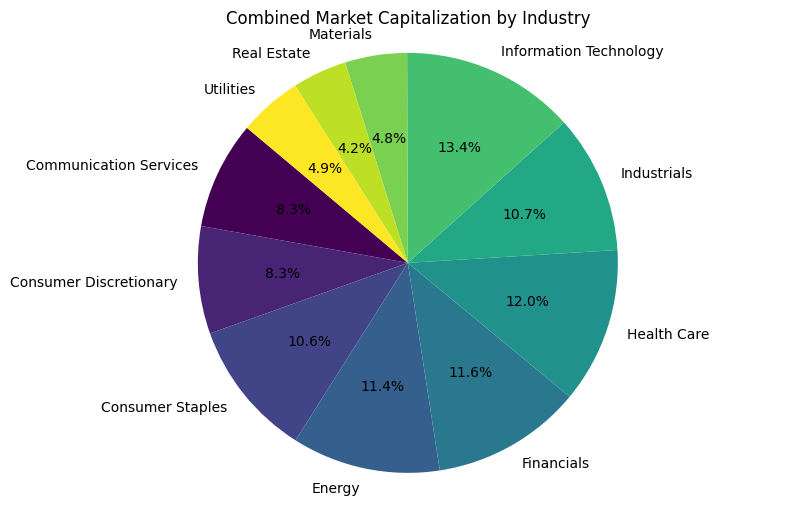

In [77]:
industry_market_cap = df2.groupby('industry')['market_cap'].sum().reset_index()

cmap = plt.get_cmap("viridis")  # Choose a colormap
colors = cmap(np.linspace(0, 1, len(industry_market_cap)))

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(industry_market_cap['market_cap'], labels=industry_market_cap['industry'], autopct='%1.1f%%', startangle=140, colors = colors)
plt.title('Combined Market Capitalization by Industry')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

If we look at the data here, we can see that the division between sectors was way more defined 12 years ago. What this means for someone who invests in the S&P500 is that he is exposed to more information technology stocks weight and are exposed to a higher beta, as tech stocks have a higher beta. This is good in times when the economy does well, but bad when the economy does not. It does point to the fact that the S&P500 has a higher risk profile than 12 years ago.